In [1]:
import numpy as np
import realization as rn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
kout, stats, hists = rn.ng.driver()

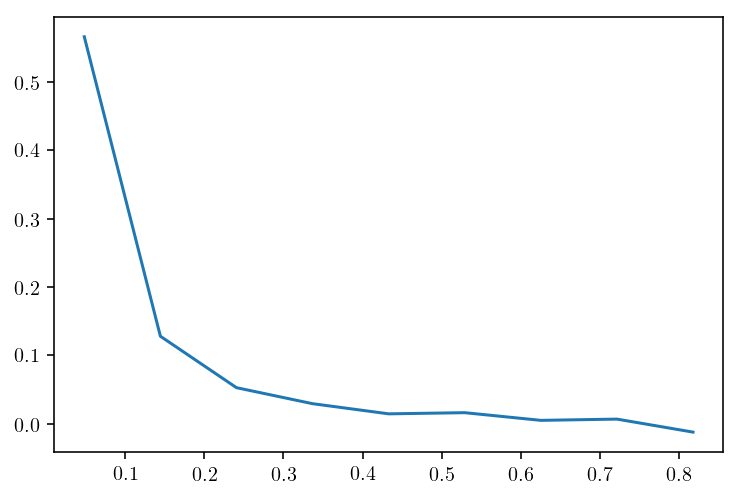

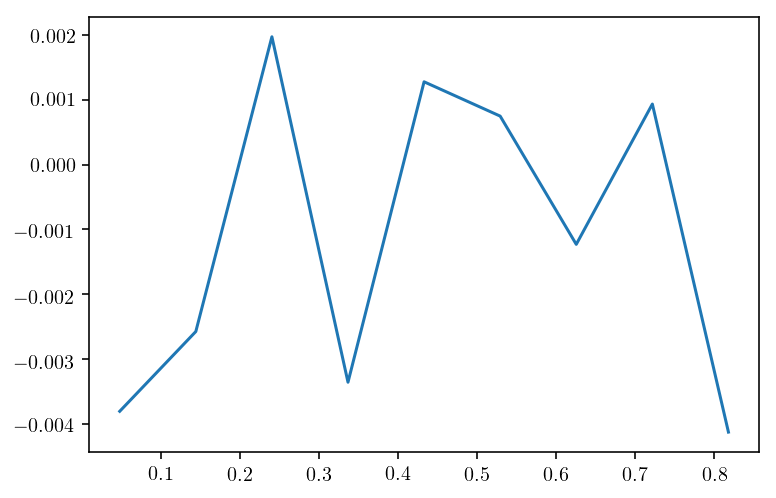

In [3]:
plt.figure(0)
plt.plot(kout, stats.T[3])
plt.figure(1)
plt.plot(kout, stats.T[2])

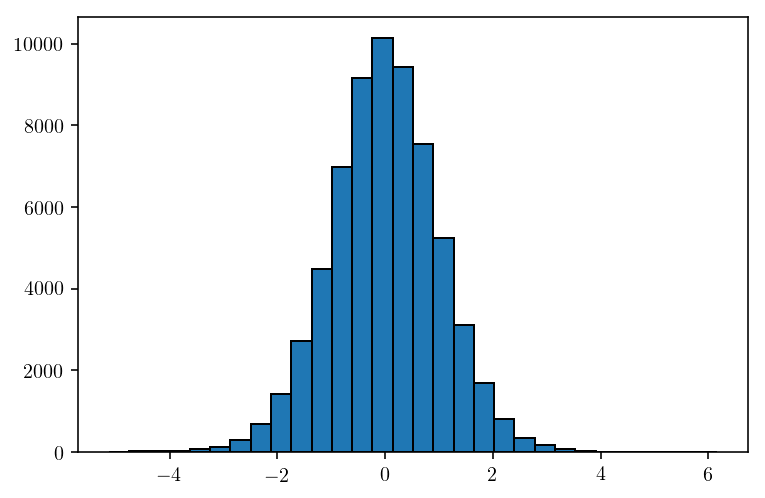

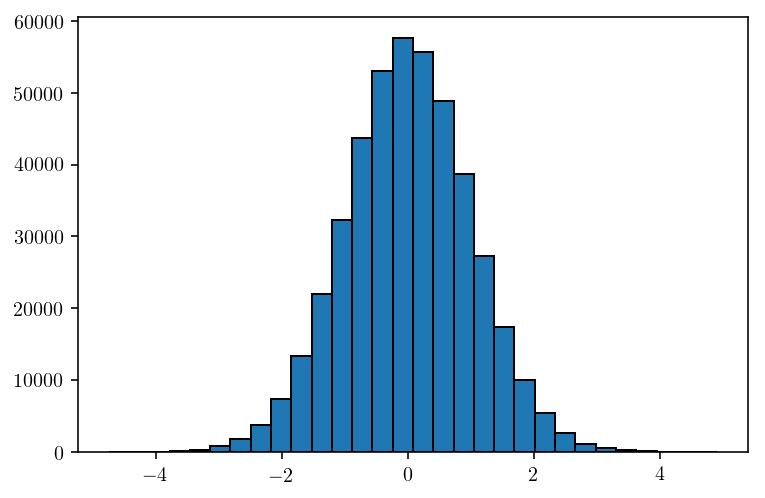

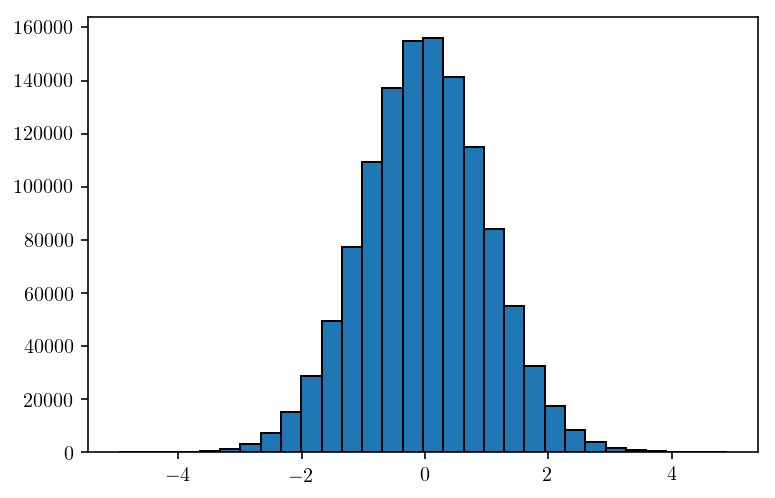

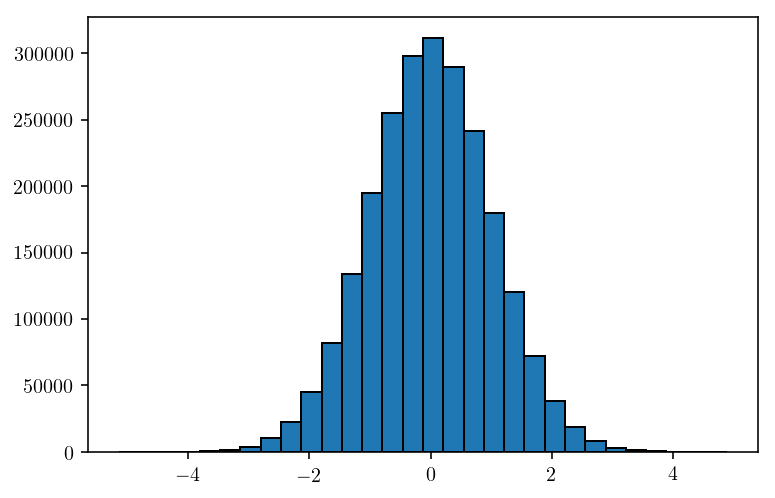

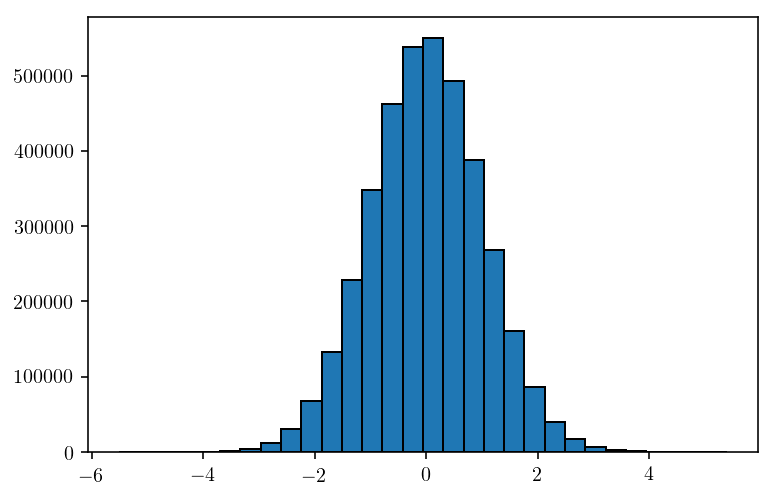

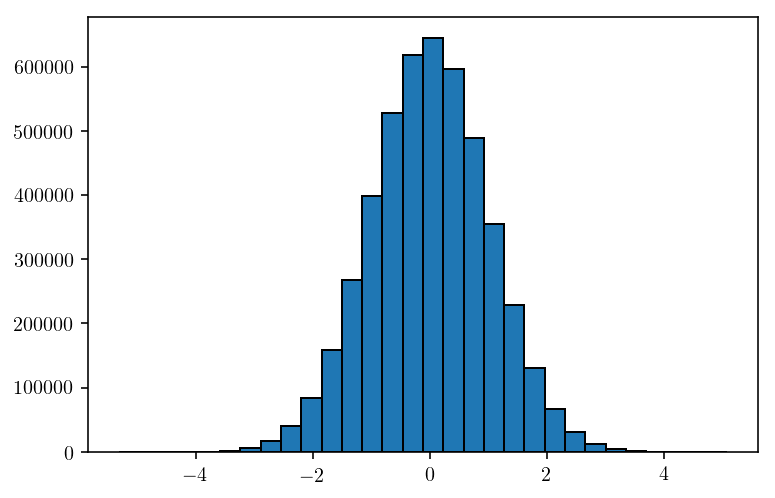

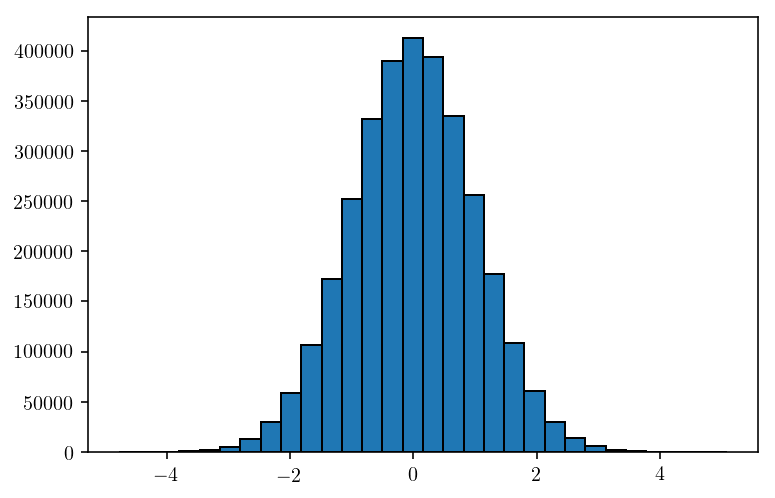

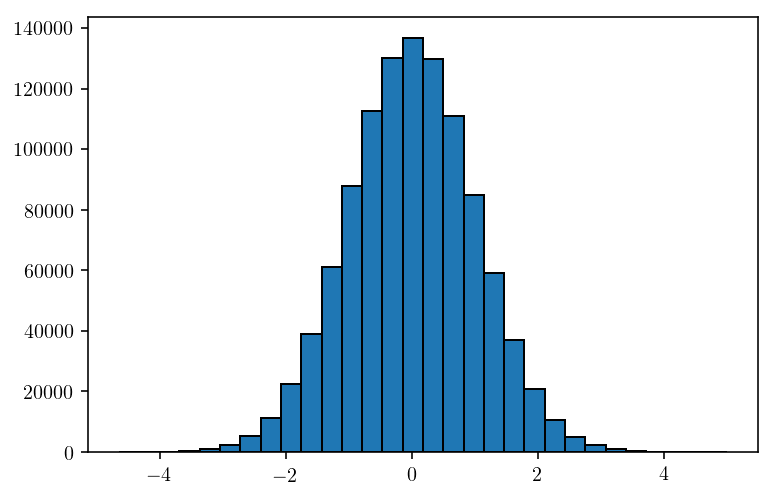

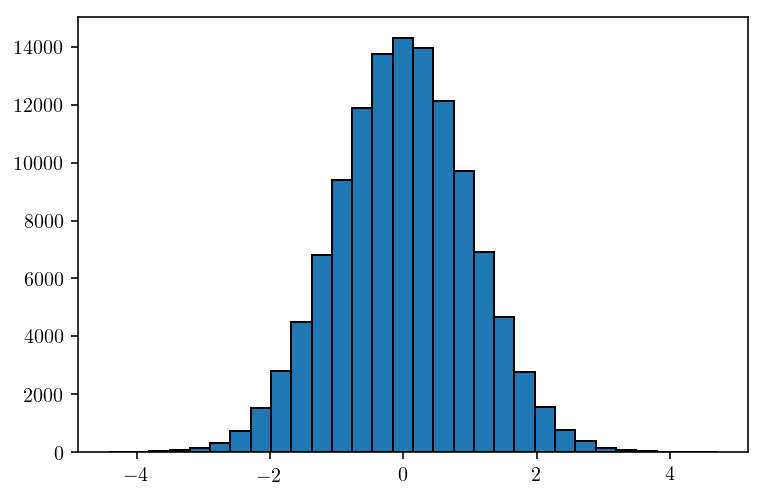

In [5]:
## see http://stackoverflow.com/questions/44003552/matplotlib-histogram-from-numpy-histogram-output
for frq, edges in hists:
    plt.bar(edges[:-1], frq, width=np.diff(edges), ec="k", align="edge")
    # plt.figure()